In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from kornia.filters import SpatialGradient

In [129]:
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'

In [130]:
# # # Dataloader
class dataset(Dataset):
    def __init__(self, dir_path, csv_file):
        super(Dataset, self).__init__()

        self.dir_path = dir_path
        self.csv_file = pd.read_csv(csv_file,index_col=0)

        self.output = self.csv_file['y_number']

        self.transform = transforms.Compose([
    transforms.ToTensor()
])

    def __len__(self):
        return self.csv_file.shape[0]
        
    def __getitem__(self, index):

        # Get the indice for the output wavefield
        self.output_im = self.output.astype(int)[index]

        inputs = [cv2.imread(self.dir_path + f'Simple_Homogeneous_Moseley_Event0000_{im}.tiff',cv2.IMREAD_UNCHANGED) for im in range(self.output_im-4,self.output_im)]
        #print(list(im for im in range(self.output_im-4,self.output_im))) # For debugging

        outputs = [cv2.imread(self.dir_path + f'Simple_Homogeneous_Moseley_Event0000_{im}.tiff',cv2.IMREAD_UNCHANGED) for im in [self.output_im]]
        #print(list(im for im in [self.output_im])) # For debugging

        inputs = self.transform(np.array(inputs))
        outputs = self.transform(np.array(outputs))
        sample = {"wave_input": inputs,
                    "wave_input_label":self.output_im,
                    "wave_output": outputs,
                    "wave_output_label":self.output_im}
        return sample

### Test Dataset

In [131]:
training_data = dataset('Simple_Homogeneous_Moseley/','Simple_Homogeneous_Moseley_Event0000_Continuous.csv')

In [132]:
sample = training_data.__getitem__(0)

In [133]:
x_4 = sample['wave_input'].transpose(1, 0)[:,::4,::4]
x_2 = sample['wave_input'].transpose(1, 0)[:,::2,::2]
x_1 = sample['wave_input'].transpose(1, 0)

gt = sample['wave_output'].transpose(1, 0)[None]

Text(0.5, 1.0, 'Output - Wavefield 10')

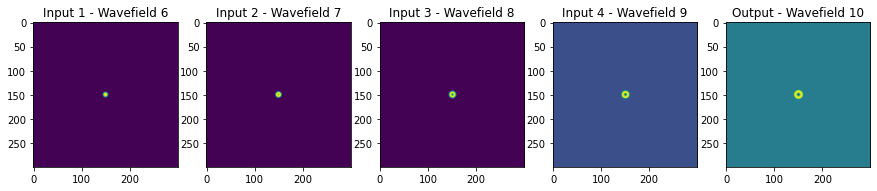

In [134]:
# # # Plot
fig, axs = plt.subplots(1,5,figsize=(15,3))

axs = axs.ravel()
for _i, ax in enumerate(axs[:-1]):
    ax.imshow(sample['wave_input'].transpose(1, 0).detach().numpy()[_i,:,:])

    wavefield = sample['wave_output_label'] - 4 + _i

    ax.set_title(f'Input {_i+1} - Wavefield {wavefield}')

axs[-1].imshow(sample['wave_output'].transpose(1, 0).detach().numpy()[0,:,:])
axs[-1].set_title('Output - Wavefield {}'.format(sample['wave_output_label']))

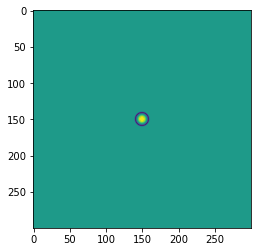

In [135]:
plt.imshow(sample['wave_input'].transpose(1, 0).detach().numpy()[3,:,:]-sample['wave_output'].transpose(1, 0).detach().numpy()[0,:,:])

### Test Dataloader

In [136]:
dataloader = DataLoader(training_data, batch_size=16, shuffle=True)

In [137]:
samples = next(iter(dataloader))
samples['wave_input'].transpose(2, 1).size()

torch.Size([16, 4, 300, 300])

In [138]:
class ConvBlock(nn.Module): 
    def __init__(self,in_channels): 
        super(ConvBlock, self).__init__()

        self.convblock = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, padding=1),
        )

    def forward(self, x):
        x = self.convblock(x)
        return x

In [139]:
class Generator(nn.Module):
    def __init__(self,in_channels): 
        super(Generator, self).__init__()

        self.convblock_1 = ConvBlock(in_channels=in_channels)
        self.convblock_2 = ConvBlock(in_channels=in_channels+1)
        self.convblock_3 = ConvBlock(in_channels=in_channels+1)

        self.upsample = nn.Upsample(scale_factor=(2,2))

    def forward(self,x_4,x_2,x_1):

        x = self.convblock_1(x_4)
        x = self.upsample(x)

        x = self.convblock_2(torch.cat((x,x_2),dim=1))
        x = self.upsample(x)

        x = self.convblock_2(torch.cat((x,x_1),dim=1))

        return x

In [140]:
layers_dict = [{'conv':{'in_channels':1,'out_channels':32,'kernel_size':(7,7),'stride':(2,2)}},
                {'conv':{'in_channels':32,'out_channels':128,'kernel_size':(7,7),'stride':(2,2)}},
                {'conv':{'in_channels':128,'out_channels':32,'kernel_size':(5,5),'stride':(2,2)}},
                {'conv':{'in_channels':32,'out_channels':8,'kernel_size':(5,5),'stride':(2,2)}}.
                {'lin':{'in_channels':8*15*15,'out_channels':512}},
                {'lin':{'in_channels':512,'out_channels':1}}]

SyntaxError: invalid syntax (<ipython-input-140-9b063f942314>, line 5)

True

In [100]:
# # # TODO 
class Discriminator(nn.Module):
    def __init__(self,layers_dict): 
        super(Discriminator, self).__init__()

        self.layers_dict = layers_dict

        self.layers = nn.ModuleList()

        for layer in self.layers_dict:
            if list(layer.keys())[0] == 'conv':
                self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(7,7),stride=(2,2))
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=128, kernel_size=(7,7),stride=(2,2))
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=32, kernel_size=(5,5),stride=(2,2))
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=8, kernel_size=(5,5),stride=(2,2))

        self.relu = nn.ReLU()

        self.lin1 = nn.Linear(in_features=8*15*15,out_features=512)
        self.lin2 = nn.Linear(in_features=512,out_features=1)

        self.sigmoid = nn.Sigmoid()

        self.flatten = nn.Flatten()
            
    def forward(self,x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))

        x = self.flatten(x)

        x = self.relu(self.lin1(x))
        x = self.sigmoid(self.lin2(x))

        return x

In [141]:
class Discriminator(nn.Module):
    def __init__(self): 
        super(Discriminator, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(7,7),stride=(2,2))
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=128, kernel_size=(7,7),stride=(2,2))
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=32, kernel_size=(5,5),stride=(2,2))
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=8, kernel_size=(5,5),stride=(2,2))

        self.relu = nn.ReLU()

        self.lin1 = nn.Linear(in_features=8*15*15,out_features=512)
        self.lin2 = nn.Linear(in_features=512,out_features=1)

        self.sigmoid = nn.Sigmoid()

        self.flatten = nn.Flatten()
            
    def forward(self,x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))

        x = self.flatten(x)

        x = self.relu(self.lin1(x))
        x = self.sigmoid(self.lin2(x))

        return x

In [142]:
model = Generator(in_channels=4)

In [143]:
gen = model(x_4[None],x_2[None],x_1[None])

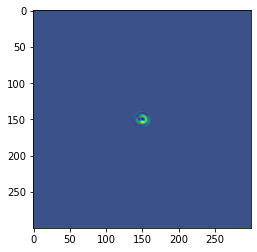

In [144]:
plt.imshow(gen[0,0].detach().numpy())

In [145]:
class GDLLoss(nn.Module):
    def __init__(self,alpha=2): 
        super(GDLLoss, self).__init__()

        self.grad = SpatialGradient(normalized=True)
        self.alpha = alpha

    def forward(self,gen,gt,alpha=2):

        self.gen_dx = self.grad(gen)[:,:,0,:,:]
        self.gen_dy = self.grad(gen)[:,:,1,:,:]
        self.gt_dx = self.grad(gt)[:,:,0,:,:]
        self.gt_dy = self.grad(gt)[:,:,1,:,:]

        self.grad_diff_x = torch.abs(self.gt_dx - self.gen_dx)
        self.grad_diff_y = torch.abs(self.gt_dy - self.gen_dy)

        return torch.mean(self.grad_diff_x ** self.alpha + self.grad_diff_y ** self.alpha)

In [146]:
class MSLoss(nn.Module):
    def __init__(self): 
        super(MSLoss, self).__init__()

        self.gdl_fn = GDLLoss()
        self.mse_fn = nn.MSELoss()
        self.bce_loss = nn.BCELoss()

    def forward(self,gen,gt,preds,trues):

        # Loss function  : L_2 (preds-true) + L_GDL (preds-true) + L_G (pred_labels;true_labels)
        
        loss_l2 = self.mse_fn(gen,gt)
        loss_gdl = self.gdl_fn(gen,gt)
        loss_bce = self.bce_loss(preds,trues)

        loss = loss_l2 + loss_gdl + loss_bce

        return loss, loss_l2, loss_gdl, loss_bce

In [156]:
# # # Training
dataloader = DataLoader(training_data, batch_size=2, shuffle=True)

netG = Generator(in_channels=4)
netG = netG.to(device)

netD = Discriminator()
netD = netD.to(device)

criterionG = MSLoss()
criterionD = nn.BCELoss()

beta1 = 0.5

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = torch.optim.Adam(netD.parameters(), lr=0.0001, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=0.001)

epochs = 50

In [153]:
for epoch in range(epochs):
    
    train_loss = 0
    train_loss_l2 = 0
    train_loss_gdl = 0
    train_loss_bce = 0

    netG.train()
    netD.train()

    for samples in dataloader:

        # # # Data

        # Inputs
        wave_input = samples['wave_input'].transpose(2, 1)
        wave_input = wave_input.to(device)
        wave_input.require_grad = True

        x_4 = wave_input[:,:,::4,::4]
        x_2 = wave_input[:,:,::2,::2]
        x_1 = wave_input

        # Outputs
        gt = samples['wave_output'].transpose(2, 1)
        gt = gt.to(device)

        #########################
        # # # Discriminator # # # 
        #########################
        # Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        
        netD.zero_grad()

        # Update with real data
        gt_size = gt.size(0)
        label = torch.full((gt_size,), real_label, dtype=torch.float, device=device) # labels with 1
        output = netD(gt).view(-1) # Classify all true batch with D

        errD_real = criterionD(output, label) 
        errD_real.backward()

        # Update with fake data
        label.fill_(fake_label) # labels with 0
        gen = netG(x_4,x_2,x_1) # Generate fake image batch with G

        output = netD(gen.detach()).view(-1) # Classify all fake batch with D
        
        errD_fake = criterionD(output, label)
        errD_fake.backward()

        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake

        # Update D
        optimizerD.step()

        #####################
        # # # Generator # # #
        #####################
        
        netG.zero_grad() # optimizer.zero_grad() ?
        label.fill_(real_label)  # fake labels are real for generator cost

        output = netD(gen).view(-1) # Since we just updated D, perform another forward pass of all-fake batch through D
        loss, loss_l2, loss_gdl, loss_bce = criterionG(gen, gt, output, label)

        loss.backward()
        optimizerG.step()

        train_loss += loss.item() * samples['wave_input'].size(0)
        train_loss_l2 += loss_l2.item() * samples['wave_input'].size(0)
        train_loss_gdl += loss_gdl.item() * samples['wave_input'].size(0)
        train_loss_bce += loss_bce.item() * samples['wave_input'].size(0)

    epoch_loss = train_loss / training_data.__len__()
    epoch_loss_l2 = train_loss_l2 / training_data.__len__()
    epoch_loss_gdl = train_loss_gdl / training_data.__len__()
    epoch_loss_bce = train_loss_bce / training_data.__len__()
    
    print('Epoch : %d, Loss : %.5e, Loss L2: %.5e, Loss GDL: %.5e, Loss BCE: %.5e' %(epoch,epoch_loss,epoch_loss_l2,epoch_loss_gdl,epoch_loss_bce))

Epoch : 0, Loss : 3.78528e+00, Loss L2: 2.60856e+00, Loss GDL: 4.61164e-01, Loss BCE: 7.15551e-01
Epoch : 1, Loss : 9.69585e-01, Loss L2: 2.11474e-01, Loss GDL: 6.27965e-02, Loss BCE: 6.95314e-01
Epoch : 2, Loss : 8.19308e-01, Loss L2: 9.09750e-02, Loss GDL: 3.45029e-02, Loss BCE: 6.93830e-01
Epoch : 3, Loss : 7.66024e-01, Loss L2: 5.12734e-02, Loss GDL: 2.10604e-02, Loss BCE: 6.93690e-01
Epoch : 4, Loss : 7.45488e-01, Loss L2: 3.83481e-02, Loss GDL: 1.47534e-02, Loss BCE: 6.92387e-01
Epoch : 5, Loss : 7.32416e-01, Loss L2: 2.88005e-02, Loss GDL: 1.18262e-02, Loss BCE: 6.91789e-01
Epoch : 6, Loss : 7.34417e-01, Loss L2: 2.57160e-02, Loss GDL: 9.95731e-03, Loss BCE: 6.98743e-01
Epoch : 7, Loss : 7.22040e-01, Loss L2: 2.02224e-02, Loss GDL: 8.40290e-03, Loss BCE: 6.93415e-01
Epoch : 8, Loss : 7.16992e-01, Loss L2: 1.67073e-02, Loss GDL: 7.14557e-03, Loss BCE: 6.93139e-01
Epoch : 9, Loss : 7.15311e-01, Loss L2: 1.55993e-02, Loss GDL: 6.54876e-03, Loss BCE: 6.93163e-01
Epoch : 10, Loss : 7

In [155]:
# # # Save model
dir_save = 'MULTISCALE_L2_GDL_BCE/'
model_G = f'G_L2_GDL_BCE_E{epochs}'
model_D = f'D_L2_GDL_BCE_E{epochs}'

if not os.path.exists(dir_save): 
    os.makedirs(dir_save)

# Save Generator
PATH = dir_save + model_G + '.pt'
torch.save(netG.state_dict(), PATH)

# Save Discriminator
PATH = dir_save + model_D + '.pt'
torch.save(netD.state_dict(), PATH)

In [224]:
# # # Testing - One sample
test_sample = training_data.__getitem__(10)

test_x = test_sample['wave_input'].transpose(1, 0)
test_x = test_x.to('cpu')
model = model.to('cpu')

x_4 = test_x[:,::4,::4]
x_2 = test_x[:,::2,::2]
x_1 = test_x

test_gen = model(x_4[None],x_2[None],x_1[None])

test_gt = test_sample['wave_output'].transpose(1, 0)[None]

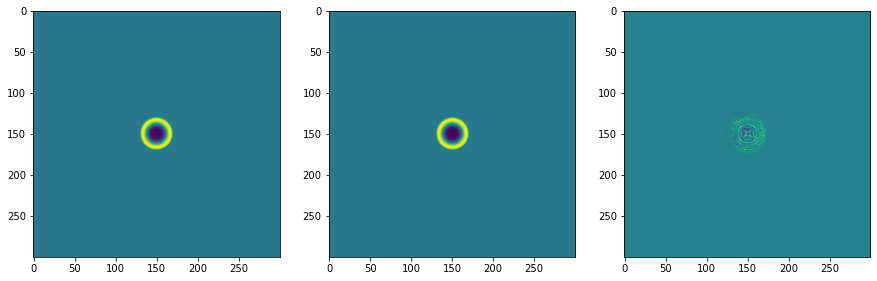

In [225]:
# # # Plot Testing - One Sample

pred = test_gen[0,0].detach().cpu().numpy()
true = test_gt[0,0].detach().cpu().numpy()
error = pred - true

fig , ax = plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(pred)
ax[1].imshow(true)
ax[2].imshow(error)

In [226]:
# # # Testing - Recursive Testing

initial_time_step = 10

initial_test_sample = training_data.__getitem__(initial_time_step)

test_x = initial_test_sample['wave_input'].transpose(1, 0)[None]
test_x = test_x.to('cpu')
model = model.to('cpu')

preds = np.zeros((50,300,300))
trues = np.zeros((50,300,300))

for ts in range(50):
    x_4 = test_x[:,:,::4,::4]
    x_2 = test_x[:,:,::2,::2]
    x_1 = test_x

    test_gen = model(x_4,x_2,x_1)

    preds[ts,:,:] = test_gen[0,0].detach().cpu().numpy()

    test_gt = training_data.__getitem__(initial_time_step+ts)['wave_output'].transpose(1, 0)[None]
    
    trues[ts,:,:] = test_gt[0,0].detach().cpu().numpy()

    test_x = torch.cat((test_x,test_gen),dim=1)[:,1:,:,:] # Concat gen wavefield as the new input wavefield

errors = preds - trues

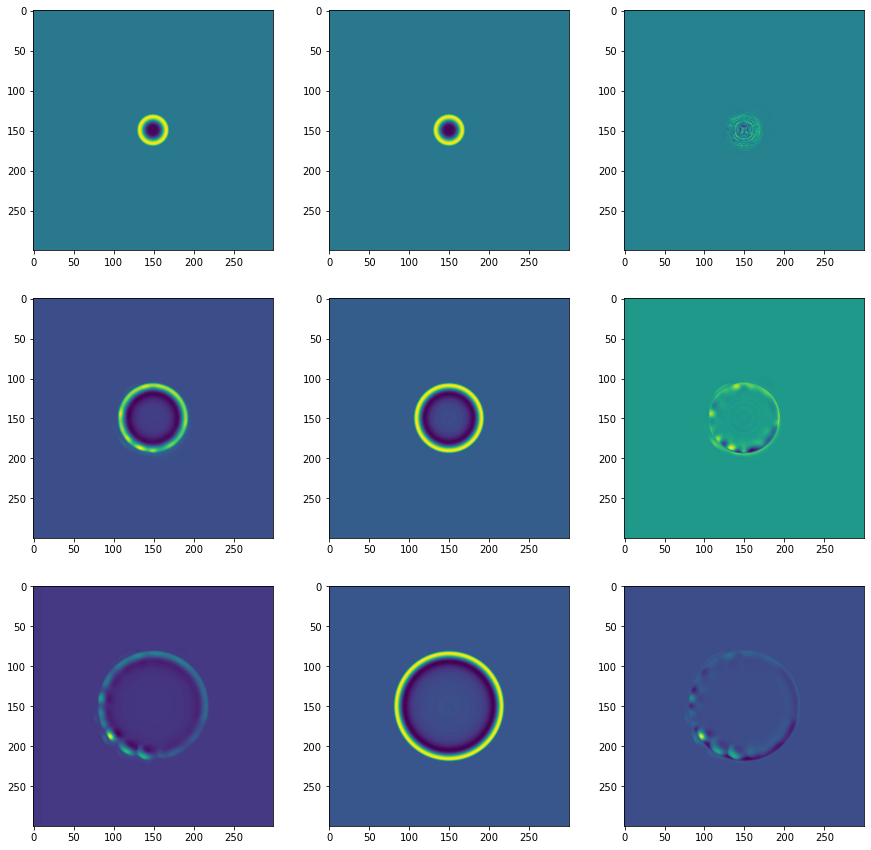

In [227]:
# # # Plot testing - multiple sample

fig , axs = plt.subplots(3,3,figsize=(15,15))

for row, ts in enumerate([0,24,49]):
    axs[row,0].imshow(preds[ts,:,:])
    axs[row,1].imshow(trues[ts,:,:])
    axs[row,2].imshow(errors[ts,:,:])

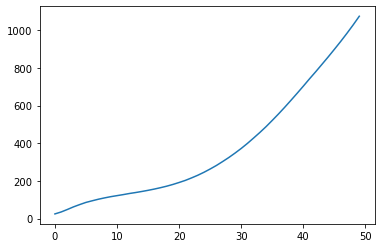

In [228]:
plt.plot(np.linalg.norm(errors,axis=(1,2)))